In [0]:
# Run this only once whenever the notebook is opened.
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!cd drive/My\ Drive/gym-bubble-trouble && pip install -e . && cd gym_bubbletrouble/envs/
!pip install pygame
%cd drive/My\ Drive/gym-bubble-trouble/gym_bubbletrouble/envs/

Obtaining file:///content/drive/My%20Drive/gym-bubble-trouble
  Found existing installation: gym-bubbletrouble 0.0.1
    Can't uninstall 'gym-bubbletrouble'. No files were found to uninstall.
  Running setup.py develop for gym-bubbletrouble
/content/drive/My Drive/gym-bubble-trouble/gym_bubbletrouble/envs


In [2]:
from bubbletrouble_env import BubbleTroubleEnv
import gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import numpy as np

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import gym.spaces

env = BubbleTroubleEnv(rand=True)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html


In [0]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


resize = T.Compose([T.ToPILImage(),
                    T.Resize(80, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    return resize(screen).unsqueeze(0).to(device)

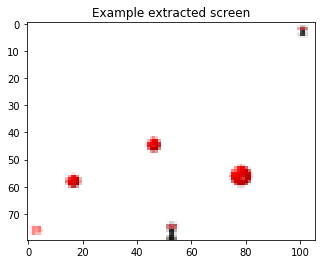

In [4]:
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [0]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state, model=policy_net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return model(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []

In [0]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.type(torch.float)

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [0]:
import copy

T_LIMIT = 25 * 30 * 2
num_episodes = 200
best_model = None
best_fitness = -10000
min_delta = 100

for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        
        _, r, done, _ = env.step(action.item())
        reward = torch.tensor([r], device=device)
        
        if t > T_LIMIT:
            r += -10000
            done = True

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
          
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        
        if done:
            episode_durations.append(t + 1)
            clear_output(wait=False)
            print('Episode {}: reward={} with {} steps'
                  .format(i_episode, r, t + 1))
            if r > best_fitness + min_delta:
              best_fitness = r
              best_model = copy.deepcopy(policy_net)
            break
            
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())      

print('Complete')
plot_durations()
env.render()
plt.ioff()
plt.show()

Episode 15: reward=-9455 with 259 steps


In [8]:
torch.save(policy_net, 'best_model')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [18]:
# Testing the policy
from gym import wrappers

best_model = torch.load('best_model')
env.reset()

last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen

img_array = []

for i in range(1000):
    img_array.append(current_screen.cpu().squeeze(0).permute(1, 2, 0).numpy())
    action = select_action(state, model=best_model)
    _, _, done, _ = env.step(action.item())
    
    last_screen = current_screen
    current_screen = get_screen()

    state = current_screen - last_screen
    if done:
      break
      
# env.close()

error: ignored

In [0]:
import cv2
import glob
 
out = cv2.VideoWriter(
    'dqn-result.mp4',
    cv2.VideoWriter_fourcc(*'DIVX'), 
    30, 
    (screen_width, screen_height)
)
for img in img_array:
    img_norm = cv2.cvtColor(np.uint8(img * 255), cv2.COLOR_BGR2RGB)
    out.write(img_norm)
out.release()
